<a href="https://colab.research.google.com/github/smannan/LIFXBulbAnalysis/blob/main/SmartBulbARIMAModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd

In [17]:
filename = '/content/drive/Shared drives/CMPE295B/FinalBulbData/2021-08-26_13_2021-09-20_21_hourly.csv'
bulb_data = pd.read_csv(filename, infer_datetime_format = True).drop(['Unnamed: 0'], axis=1, inplace=False)
bulb_data['timestamp'] = pd.to_datetime(bulb_data['timestamp'])

In [18]:
bulb_data.head()

,timestamp,brightness,kelvin,kWH
0,2021-08-26 13:00:00,1.0,2700.0,0.119
1,2021-08-26 14:00:00,1.0,2700.0,0.510
2,2021-08-26 15:00:00,1.0,2700.0,0.510
3,2021-08-26 16:00:00,1.0,2700.0,0.510
4,2021-08-26 17:00:00,1.0,2700.0,0.510


### Visualize time series data

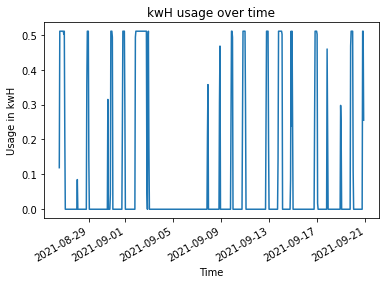

In [43]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

plt.plot(bulb_data['timestamp'], bulb_data['kWH'])
plt.gcf().autofmt_xdate()
plt.title('kwH usage over time')
plt.ylabel('Usage in kwH')
plt.xlabel('Time')
plt.show()

### View autocorrelation plot
- How correlated are current timesteps to previous ones

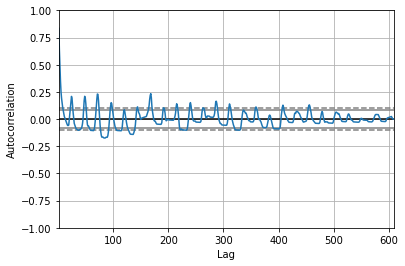

In [26]:
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(bulb_data[['kWH']])
plt.show()

- Looks like there is not a lot of correlation between timesteps?
- Confidence interval = 95% so focus on correlations within this interval as they are likely not statistical flukes
- Most lags are between (-0.2, 0.2) correlation with 95% confidence



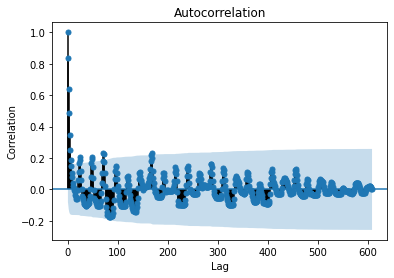

In [33]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(bulb_data[['kWH']], lags=len(bulb_data)-1)
plt.xlabel('Lag')
plt.ylabel('Correlation')
plt.show()

### View partial autocorrelation
- Removes indirect relationships between lags

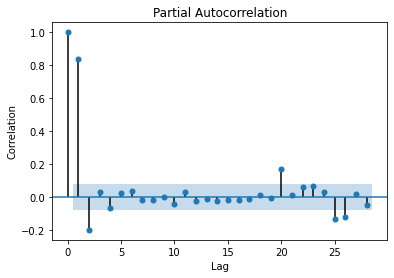

In [41]:
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(bulb_data[['kWH']])
plt.xlabel('Lag')
plt.ylabel('Correlation')
plt.show()

### Summary
- ACF correlation should be strong for the first k lags then taper off
- PACF should have *no* correlation after k
- The first 5 steps or so look like they are correlated but this tapers off afterwards?
- Doesn't look like the data is highly correlated over long periods of time
- Would make sense because usage patterns are daily, 3-4 hours in the evening?
- Want data to be stationary - remove any trends beforehand analysis?
- No seasonal trends